Problem Statement:Build a Movie Recommendation System using Collaborative Filtering techniques. The goal is to predict how a user would rate a particular movie based on their past ratings and similarities between users or movies.

In [1]:
import numpy as np
import pandas as pd

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
movies=pd.read_csv("/content/drive/MyDrive/Scaler/recommender systems/case study/zee-movies.dat",sep='::',encoding="latin-1")
ratings=pd.read_csv("/content/drive/MyDrive/Scaler/recommender systems/case study/zee-ratings.dat",sep='::',encoding="latin-1")
users=pd.read_csv("/content/drive/MyDrive/Scaler/recommender systems/case study/zee-users.dat",sep='::',encoding="latin-1")

/tmp/ipython-input-974572898.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  movies=pd.read_csv("/content/drive/MyDrive/Scaler/recommender systems/case study/zee-movies.dat",sep='::',encoding="latin-1")
/tmp/ipython-input-974572898.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  ratings=pd.read_csv("/content/drive/MyDrive/Scaler/recommender systems/case study/zee-ratings.dat",sep='::',encoding="latin-1")
/tmp/ipython-input-974572898.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are i

In [4]:
movies.head(2),ratings.head(2),users.head(2)

(   Movie ID             Title                        Genres
 0         1  Toy Story (1995)   Animation|Children's|Comedy
 1         2    Jumanji (1995)  Adventure|Children's|Fantasy,
    UserID  MovieID  Rating  Timestamp
 0       1     1193       5  978300760
 1       1      661       3  978302109,
    UserID Gender  Age  Occupation Zip-code
 0       1      F    1          10    48067
 1       2      M   56          16    70072)

Preprocessing steps


*   Transforming the Genres from movies into binary features


*   Transforming the timestamp from the ratings


*   Transforming the gender from users into binary values



In [5]:
m=movies.copy()
m['Genres']=m['Genres'].str.split("|")


In [6]:
m.head()

,Movie ID,Title,Genres
0,1,Toy Story (1995),"[Animation, Children's, Comedy]"
1,2,Jumanji (1995),"[Adventure, Children's, Fantasy]"
2,3,Grumpier Old Men (1995),"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),"[Comedy, Drama]"
4,5,Father of the Bride Part II (1995),[Comedy]


In [7]:
m=m.explode('Genres')

In [8]:
m.head()

,Movie ID,Title,Genres
0,1,Toy Story (1995),Animation
0,1,Toy Story (1995),Children's
0,1,Toy Story (1995),Comedy
1,2,Jumanji (1995),Adventure
1,2,Jumanji (1995),Children's


In [9]:
m=m.pivot(index='Movie ID',columns='Genres',values='Title')
m = ~m.isna()
m = m.astype(int)
m.head(2)

Genres,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
Movie ID,,,,,,,,,,,,,,,,,,
1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [10]:
from datetime import datetime
r=ratings.copy()
r['hour']=r['Timestamp'].apply(lambda x: datetime.fromtimestamp(x).hour)

In [11]:
r.head()

,UserID,MovieID,Rating,Timestamp,hour
0,1,1193,5,978300760,22
1,1,661,3,978302109,22
2,1,914,3,978301968,22
3,1,3408,4,978300275,22
4,1,2355,5,978824291,23


Adding the average ratings and average timestamp to the user data

In [12]:
users=users.merge(r.groupby('UserID')[['Rating','hour']].mean().reset_index(),on='UserID')

In [13]:
users.head()

,UserID,Gender,Age,Occupation,Zip-code,Rating,hour
0,1,F,1,10,48067,4.188679,22.245283
1,2,M,56,16,70072,3.713178,21.155039
2,3,M,25,15,55117,3.901961,21.000000
3,4,M,45,7,02460,4.190476,20.000000
4,5,M,25,20,55455,3.146465,6.015152


In [14]:
users['Gender']=users['Gender'].map({'F':0,'M':1})

In [15]:
users.head()

,UserID,Gender,Age,Occupation,Zip-code,Rating,hour
0,1,0,1,10,48067,4.188679,22.245283
1,2,1,56,16,70072,3.713178,21.155039
2,3,1,25,15,55117,3.901961,21.000000
3,4,1,45,7,02460,4.190476,20.000000
4,5,1,25,20,55455,3.146465,6.015152


Creating the final Feature Matrix

In [16]:
X = ratings[['UserID', 'MovieID', 'Rating']].copy()

In [17]:
m.reset_index(inplace=True)

In [18]:
m.columns

Index(['Movie ID', 'Action', 'Adventure', 'Animation', 'Children's', 'Comedy',
       'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror',
       'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War',
       'Western'],
      dtype='object', name='Genres')

In [19]:
m.rename(columns={"Movie ID": "MovieID"}, inplace=True)

In [20]:

X = X.merge(users.reset_index(), on='UserID', how='right')

X = X.merge(m, on='MovieID', how='right')
X.head()

,UserID,MovieID,Rating_x,index,Gender,Age,Occupation,Zip-code,Rating_y,hour,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1.0,1,5.0,0.0,0.0,1.0,10.0,48067,4.188679,22.245283,...,0,0,0,0,0,0,0,0,0,0
1,6.0,1,4.0,5.0,0.0,50.0,9.0,55117,3.901408,4.042254,...,0,0,0,0,0,0,0,0,0,0
2,8.0,1,4.0,7.0,1.0,25.0,12.0,11413,3.884892,2.215827,...,0,0,0,0,0,0,0,0,0,0
3,9.0,1,5.0,8.0,1.0,25.0,17.0,61614,3.735849,1.000000,...,0,0,0,0,0,0,0,0,0,0
4,10.0,1,5.0,9.0,0.0,35.0,1.0,95370,4.114713,6.723192,...,0,0,0,0,0,0,0,0,0,0


In [21]:
X.rename(columns={'Rating_x':'Rating','Rating_y':'Average_Rating'},inplace=True)

In [22]:
X.head()

,UserID,MovieID,Rating,index,Gender,Age,Occupation,Zip-code,Average_Rating,hour,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1.0,1,5.0,0.0,0.0,1.0,10.0,48067,4.188679,22.245283,...,0,0,0,0,0,0,0,0,0,0
1,6.0,1,4.0,5.0,0.0,50.0,9.0,55117,3.901408,4.042254,...,0,0,0,0,0,0,0,0,0,0
2,8.0,1,4.0,7.0,1.0,25.0,12.0,11413,3.884892,2.215827,...,0,0,0,0,0,0,0,0,0,0
3,9.0,1,5.0,8.0,1.0,25.0,17.0,61614,3.735849,1.000000,...,0,0,0,0,0,0,0,0,0,0
4,10.0,1,5.0,9.0,0.0,35.0,1.0,95370,4.114713,6.723192,...,0,0,0,0,0,0,0,0,0,0


In [23]:
ratings.head()

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [24]:
rm = ratings.pivot(index = 'UserID', columns ='MovieID', values = 'Rating').fillna(0)
rm.head()

MovieID,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
UserID,,,,,,,,,,,,,,,,,,,,,
1,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
(rm > 0).sum().sum() / (rm.shape[0] * rm.shape[1])*100

np.float64(4.468362562231285)

In [26]:
!pip install cmfrec

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.5/268.5 kB 8.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached findblas-0.1.26.post1-py3-none-any.whl
ERROR: Operation cancelled by user


In [ ]:
rm_raw = ratings[['UserID', 'MovieID', 'Rating']].copy()

In [ ]:
rm_raw.columns

Index(['UserId', 'ItemId', 'Rating'], dtype='object')

Person correlation to get recommendation

In [ ]:
data_rating=rm_raw.pivot(index='UserId',columns='ItemId',values='Rating').fillna(0)

In [ ]:
data_rating.head(2)

ItemId,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
UserId,,,,,,,,,,,,,,,,,,,,,
1,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
def movie_recommendation_person(movie_id,n=5):
  # calculate the correlation between a movie rating with the rating of all other movie.
  x=data_rating.corrwith(data_rating[movie_id]).sort_values(ascending=False).reset_index()
  x.dropna(inplace=True)
  return x.head(n)


In [ ]:
movie_name = 5
recommended_movies = movie_recommendation_person(movie_name, n=5)
id_to_title = dict(zip(movies['Movie ID'], movies['Title']))
recommended_movies['Title'] = recommended_movies['ItemId'].map(id_to_title)
print(f" Movies similar to '{movie_name}':")
print(recommended_movies)

 Movies similar to '5':
   ItemId         0                                  Title
0       5  1.000000     Father of the Bride Part II (1995)
1     586  0.376433                      Home Alone (1990)
2    2953  0.374349  Home Alone 2: Lost in New York (1992)
3    2082  0.357558               Mighty Ducks, The (1992)
4     186  0.342925                     Nine Months (1995)


In [ ]:
#user-item CSR
from scipy.sparse import csr_matrix
user_item_csr=csr_matrix(data_rating)


<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 1000209 stored elements and shape (6040, 3706)>

Printing the item  Cosine similarity matrix and user  cosine similarity matrix

In [ ]:
user_item_csr

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 1000209 stored elements and shape (6040, 3706)>

In [ ]:
#user-user cosine similarity
from sklearn.metrics.pairwise import cosine_similarity
user_similarity=cosine_similarity(user_item_csr)
user_similarity_csr = csr_matrix(user_similarity)

print(user_similarity_csr.shape)

(6040, 6040)


In [ ]:
#item to item similarity
# we take transponse of the user item matrix befor giving it to the cosine_similarity funcion
item_similarity=cosine_similarity(user_item_csr.T)
item_similarity_csr = csr_matrix(item_similarity)

print(item_similarity_csr.shape)

(3706, 3706)


 A function to return top 5 recommendations for a given item.

In [ ]:

item=10
item_ids = data_rating.columns
x=item_similarity[item][:]
d={'Item_id':item_ids,"Similarity":x}
df_item=pd.DataFrame(d)

In [ ]:
df_item.sort_values(by='Similarity',axis=0,ascending=False).head(5)

,Item_id,Similarity
10,11,1.000000
426,440,0.568908
525,539,0.553659
583,597,0.520240
1294,1393,0.519577


Matrix Factorization

In [ ]:
print(rm_raw.columns.tolist())

['UserID', 'MovieID', 'Rating']


In [ ]:
rm_raw.rename(columns={
    'UserID': 'UserId',
    'MovieID': 'ItemId'
}, inplace=True)

In [ ]:
from cmfrec import CMF

model = CMF(method="als", k=2, lambda_=0.1, user_bias=False, item_bias=False, verbose=False)
model.fit(rm_raw)

Collective matrix factorization model
(explicit-feedback variant)


In [ ]:
model.A_.shape, model.B_.shape

((6040, 2), (3706, 2))

In [ ]:
rm_raw.Rating.mean(), model.glob_mean_

(np.float64(3.581564453029317), 3.581564426422119)

In [ ]:
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error
rm__ = np.dot(model.A_, model.B_.T) + model.glob_mean_
print("The MSE is :",mean_squared_error(rm.values[rm > 0], rm__[rm > 0])**0.5)
print("The MAPE is :",mean_absolute_percentage_error(rm.values[rm > 0], rm__[rm > 0]))

The MSE is : 1.3043536679938734
The MAPE is : 0.3765643749528522


In [ ]:
# Get user and item embeddings
user_emb = model.A_
item_emb = model.B_

Visualization with d=2

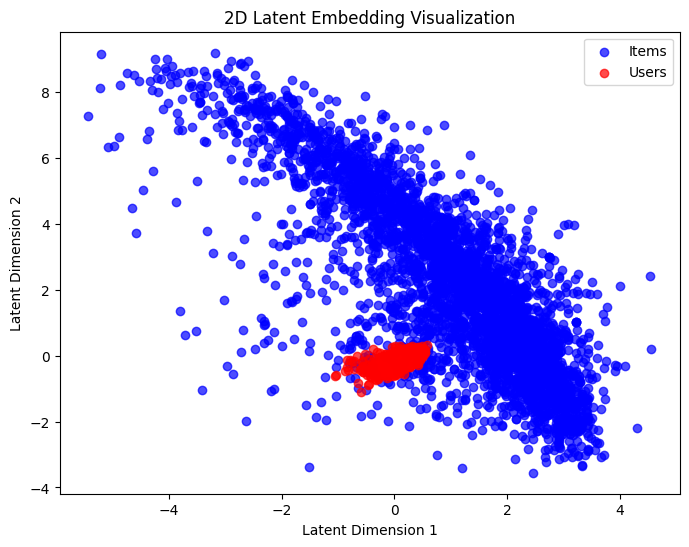

In [ ]:
import matplotlib.pyplot as plt
# Plot items in 2D space
plt.figure(figsize=(8, 6))
plt.scatter(item_emb[:, 0], item_emb[:, 1], alpha=0.7, label='Items', color='blue')
plt.scatter(user_emb[:, 0], user_emb[:, 1], alpha=0.7, label='Users', color='red')
plt.title("2D Latent Embedding Visualization")
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.legend()
plt.show()


Inference:


*   The blue points (movies) are more spread out thus the model has learned greater diversity among item features.
*   The red points (users) are tightly clustered  thus the users generally have overlapping preferences or similar rating behavior.



redesigning the Matrix Factorization with k=4

In [ ]:
model_4 = CMF(method="als", k=4, lambda_=0.1, user_bias=False, item_bias=False, verbose=False)
model_4.fit(rm_raw)

Collective matrix factorization model
(explicit-feedback variant)


In [ ]:
model_4.A_.shape, model_4.B_.shape

((6040, 4), (3706, 4))

In [ ]:
rm_raw.Rating.mean(), model_4.glob_mean_

(np.float64(3.581564453029317), 3.581564426422119)

In [ ]:
rm4__ = np.dot(model_4.A_, model_4.B_.T) + model_4.glob_mean_
print("The MSE is :",mean_squared_error(rm.values[rm > 0], rm4__[rm > 0])**0.5)
print("The MAPE is :",mean_absolute_percentage_error(rm.values[rm > 0], rm4__[rm > 0]))

The MSE is : 1.3451500957006446
The MAPE is : 0.37818748754790316


In [ ]:
# Get user and item embeddings
user_emb_4 = model_4.A_
item_emb_4 = model_4.B_

In [ ]:
print(dir(model_4))

['A_', 'Ai_', 'B_', 'Bi_', 'C_', 'C_bias_', 'Cbin_', 'D_', 'D_bias_', 'Dbin_', 'NA_as_zero', 'NA_as_zero_item', 'NA_as_zero_user', '_A_pred', '_B_plus_bias', '_B_pred', '_BeTBe', '_BeTBeChol', '_BiTBi', '_BtB', '_BtXbias', '_CtC', '_CtUbias', '_I_colmeans', '_I_cols', '_Ib_cols', '_TransBtBinvBt', '_TransCtCinvCt', '_U_colmeans', '_U_cols', '_Ub_cols', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__is_fitted__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_append_NAs', '_convert_ids', '_decompose_coo', '_factors_cold', '_factors_cold_multiple', '_factors_multiple', '_factors_multiple_common', '_factors_warm', '_factors_warm_common', '_fit', '_fit_common', '_implicit', '_init', '_item_factors_cold', '_k_main_col', '_k_

Visualization using d=4

In [ ]:
from sklearn.decomposition import PCA
pca=PCA(n_components=2)
user_emb_4_pca=pca.fit_transform(user_emb_4)
item_emb_4_pca=pca.fit_transform(item_emb_4)

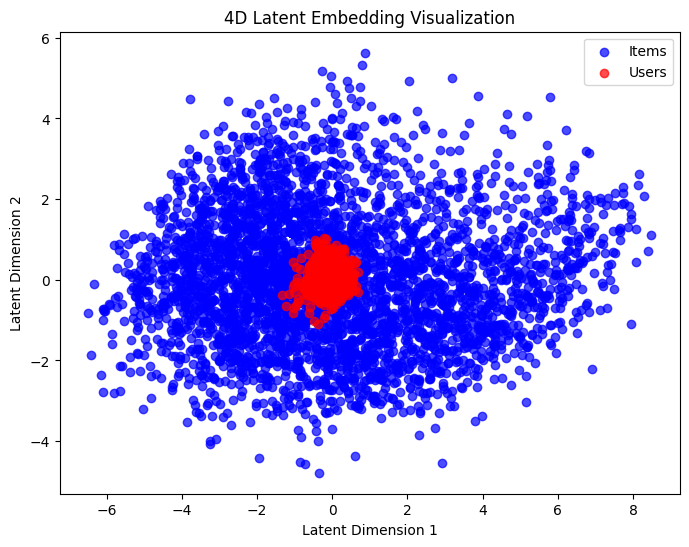

In [ ]:
import matplotlib.pyplot as plt
# Plot items in 2D space
plt.figure(figsize=(8, 6))
plt.scatter(item_emb_4_pca[:, 0], item_emb_4_pca[:, 1], alpha=0.7, label='Items', color='blue')
plt.scatter(user_emb_4_pca[:, 0], user_emb_4_pca[:, 1], alpha=0.7, label='Users', color='red')
plt.title("4D Latent Embedding Visualization")
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.legend()
plt.show()

Inference:


*   Blue dots i.e movies , the model has learned diverse item embeddings.The shape indicates no single dominant direction
*   This is a healthier structure than the elongated diagonal seen  for d=2.


*   Items near the user cluster center are mainstream movies,liked by most users.Items further away on the edges are specialized or niche movies, liked by smaller subsets of users.






Users of which age group have watched and rated the most number of movies?


*   Pople in the age group of 25-34 has rated most number of movies



In [ ]:
X.head()

,UserID,MovieID,Rating,index,Gender,Age,Occupation,Zip-code,Average_Rating,hour,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1.0,1,5.0,0.0,0.0,1.0,10.0,48067,4.188679,22.245283,...,0,0,0,0,0,0,0,0,0,0
1,6.0,1,4.0,5.0,0.0,50.0,9.0,55117,3.901408,4.042254,...,0,0,0,0,0,0,0,0,0,0
2,8.0,1,4.0,7.0,1.0,25.0,12.0,11413,3.884892,2.215827,...,0,0,0,0,0,0,0,0,0,0
3,9.0,1,5.0,8.0,1.0,25.0,17.0,61614,3.735849,1.000000,...,0,0,0,0,0,0,0,0,0,0
4,10.0,1,5.0,9.0,0.0,35.0,1.0,95370,4.114713,6.723192,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
res=X.groupby(by='Age')[['hour','Rating']].count()

In [ ]:
res.sort_values(by='hour',axis=0,ascending=False)

,hour,Rating
Age,,
25.0,395556,395556
35.0,199003,199003
18.0,183536,183536
45.0,83633,83633
50.0,72490,72490
56.0,38780,38780
1.0,27211,27211


Users belonging to which profession have watched and rated the most movies?


*   4: "college/grad student" has watched and rated most movies




In [ ]:
res=X.groupby(by='Occupation')['Rating'].count()
res.sort_values(ascending=False)

,Rating
Occupation,
4.0,131032
0.0,130499
7.0,105425
1.0,85351
17.0,72816
20.0,60397
12.0,57214
2.0,50068
14.0,49109


Most of the users in our dataset who’ve rated the movies are Male?


*   False , It is Female.



In [ ]:
res=X.groupby(by='Gender')['Rating'].count()
res

,Rating
Gender,
0.0,246440
1.0,753769


Most of the movies present in our dataset were released in which decade?
ANS: In the 90's decade most movies are released.

In [ ]:
X['Year']=movies['Title'].str.extract(r'\((\d{4})\)').astype(int)

In [ ]:
X.head()

,UserID,MovieID,Rating,index,Gender,Age,Occupation,Zip-code,Average_Rating,hour,...,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,Year
0,1.0,1,5.0,0.0,0.0,1.0,10.0,48067,4.188679,22.245283,...,0,0,0,0,0,0,0,0,0,1995.0
1,6.0,1,4.0,5.0,0.0,50.0,9.0,55117,3.901408,4.042254,...,0,0,0,0,0,0,0,0,0,1995.0
2,8.0,1,4.0,7.0,1.0,25.0,12.0,11413,3.884892,2.215827,...,0,0,0,0,0,0,0,0,0,1995.0
3,9.0,1,5.0,8.0,1.0,25.0,17.0,61614,3.735849,1.000000,...,0,0,0,0,0,0,0,0,0,1995.0
4,10.0,1,5.0,9.0,0.0,35.0,1.0,95370,4.114713,6.723192,...,0,0,0,0,0,0,0,0,0,1995.0


In [ ]:
X.groupby(by='Year')['MovieID'].count().sort_values(ascending=False)

,MovieID
Year,
1996.0,345
1995.0,342
1998.0,337
1997.0,315
1999.0,283
...,...
1923.0,3
1929.0,3
1920.0,2


The movie with maximum no. of ratings is **Champ, The (1979**).

In [ ]:
res=X.groupby(by='MovieID')['Rating'].count()

res.sort_values(ascending=False).head(1).map(id_to_title)

,Rating
MovieID,
2858,"Champ, The (1979)"


Name the top 3 movies similar to ‘Liar Liar’ on the item-based approach.


*   The top 3 movies similar to Liar Liar are **L.A. Confidential,Usual Suspects, The and Fargo.**



In [ ]:
X['Title']=X['MovieID'].map(id_to_title)

In [ ]:
X['Title'] = X['Title'].str.replace(r'\s*\(\d{4}\)', '', regex=True)

In [ ]:
item=X[X['Title']=='Liar Liar']['MovieID']
item

In [ ]:

item=1485
item_ids = data_rating.columns
x=item_similarity[item][:]
d={'Item_id':item_ids,"Similarity":x}
df_item=pd.DataFrame(d)

In [ ]:
res=df_item.sort_values(by='Similarity',axis=0,ascending=False).head(3)
res['Similar Title']=res['Item_id'].map(id_to_title)
res

,Item_id,Similarity,Similar Title
1485,1617,1.000000,L.A. Confidential (1997)
49,50,0.664798,"Usual Suspects, The (1995)"
593,608,0.661171,Fargo (1996)


On the basis of approach, Collaborative Filtering methods can be classified into **Memory-based and Model-based**.

Pearson Correlation ranges between **-1 to +1** whereas, Cosine Similarity belongs to the interval between **0 to 1**.

Mention the RMSE and MAPE that you got while evaluating the Matrix Factorization model.


*   The MSE is : 1.3451500957006446 and The MAPE is : 0.37818748754790316 for d=4
*   The MSE is : 1.3043536679938734 and The MAPE is : 0.3765643749528522 for d=2



Give the sparse ‘row’ matrix representation for the following dense matrix -

[[1 0]
[3 7]]

In [ ]:
matrix=[[1, 0],
[3, 7]]

In [ ]:
matrix_csr = csr_matrix(matrix)

print(matrix_csr.shape)
print(matrix_csr.data)
print(matrix_csr.indices)
print(matrix_csr.indptr)

(2, 2)
[1 3 7]
[0 0 1]
[0 1 3]
